  2%|▏         | 1/50 [00:15<12:28, 15.28s/it]

Episode: 1/50, Score: 9.0, Epsilon: 0.995


  4%|▍         | 2/50 [00:36<15:07, 18.90s/it]

Episode: 2/50, Score: 12.0, Epsilon: 0.990


  6%|▌         | 3/50 [00:58<15:43, 20.07s/it]

Episode: 3/50, Score: 21.0, Epsilon: 0.985


  8%|▊         | 4/50 [01:18<15:31, 20.25s/it]

Episode: 4/50, Score: 29.0, Epsilon: 0.980


 10%|█         | 5/50 [01:34<13:53, 18.52s/it]

Episode: 5/50, Score: 9.0, Epsilon: 0.975


 12%|█▏        | 6/50 [01:51<13:15, 18.08s/it]

Episode: 6/50, Score: 13.0, Epsilon: 0.970


 14%|█▍        | 7/50 [02:15<14:21, 20.04s/it]

Episode: 7/50, Score: 18.0, Epsilon: 0.966


 16%|█▌        | 8/50 [02:37<14:26, 20.64s/it]

Episode: 8/50, Score: 19.0, Epsilon: 0.961


 18%|█▊        | 9/50 [03:01<14:45, 21.59s/it]

Episode: 9/50, Score: 18.0, Epsilon: 0.956


 20%|██        | 10/50 [03:22<14:20, 21.51s/it]

Episode: 10/50, Score: 15.0, Epsilon: 0.951


 22%|██▏       | 11/50 [03:44<14:02, 21.60s/it]

Episode: 11/50, Score: 16.0, Epsilon: 0.946


 24%|██▍       | 12/50 [04:05<13:43, 21.66s/it]

Episode: 12/50, Score: 15.0, Epsilon: 0.942


 26%|██▌       | 13/50 [04:20<11:59, 19.45s/it]

Episode: 13/50, Score: 6.0, Epsilon: 0.937


 28%|██▊       | 14/50 [04:38<11:28, 19.11s/it]

Episode: 14/50, Score: 13.0, Epsilon: 0.932


 30%|███       | 15/50 [05:01<11:45, 20.15s/it]

Episode: 15/50, Score: 23.0, Epsilon: 0.928


 32%|███▏      | 16/50 [05:20<11:12, 19.79s/it]

Episode: 16/50, Score: 6.0, Epsilon: 0.923


 34%|███▍      | 17/50 [05:39<10:44, 19.54s/it]

Episode: 17/50, Score: 14.0, Epsilon: 0.918


 36%|███▌      | 18/50 [06:02<10:57, 20.55s/it]

Episode: 18/50, Score: 24.0, Epsilon: 0.914


 38%|███▊      | 19/50 [06:27<11:24, 22.08s/it]

Episode: 19/50, Score: 27.0, Epsilon: 0.909


 40%|████      | 20/50 [06:48<10:52, 21.77s/it]

Episode: 20/50, Score: 18.0, Epsilon: 0.905


 42%|████▏     | 21/50 [07:09<10:20, 21.40s/it]

Episode: 21/50, Score: 8.0, Epsilon: 0.900


 44%|████▍     | 22/50 [07:50<12:42, 27.24s/it]

Episode: 22/50, Score: 17.0, Epsilon: 0.896


 46%|████▌     | 23/50 [08:26<13:26, 29.89s/it]

Episode: 23/50, Score: 19.0, Epsilon: 0.891


 48%|████▊     | 24/50 [08:44<11:25, 26.37s/it]

Episode: 24/50, Score: 15.0, Epsilon: 0.887


 50%|█████     | 25/50 [08:59<09:32, 22.90s/it]

Episode: 25/50, Score: 9.0, Epsilon: 0.882


 52%|█████▏    | 26/50 [09:18<08:44, 21.85s/it]

Episode: 26/50, Score: 17.0, Epsilon: 0.878


 54%|█████▍    | 27/50 [09:40<08:25, 22.00s/it]

Episode: 27/50, Score: 12.0, Epsilon: 0.873


 56%|█████▌    | 28/50 [10:14<09:19, 25.45s/it]

Episode: 28/50, Score: 32.0, Epsilon: 0.869


 58%|█████▊    | 29/50 [10:35<08:29, 24.28s/it]

Episode: 29/50, Score: 11.0, Epsilon: 0.865


 60%|██████    | 30/50 [10:54<07:29, 22.48s/it]

Episode: 30/50, Score: 16.0, Epsilon: 0.860


 62%|██████▏   | 31/50 [11:17<07:10, 22.66s/it]

Episode: 31/50, Score: 8.0, Epsilon: 0.856


 64%|██████▍   | 32/50 [11:36<06:31, 21.74s/it]

Episode: 32/50, Score: 11.0, Epsilon: 0.852


 66%|██████▌   | 33/50 [12:00<06:18, 22.28s/it]

Episode: 33/50, Score: 14.0, Epsilon: 0.848


 68%|██████▊   | 34/50 [12:24<06:04, 22.76s/it]

Episode: 34/50, Score: 23.0, Epsilon: 0.843


 70%|███████   | 35/50 [12:43<05:26, 21.74s/it]

Episode: 35/50, Score: 17.0, Epsilon: 0.839


 72%|███████▏  | 36/50 [13:02<04:52, 20.91s/it]

Episode: 36/50, Score: 9.0, Epsilon: 0.835


 74%|███████▍  | 37/50 [13:20<04:19, 19.94s/it]

Episode: 37/50, Score: 11.0, Epsilon: 0.831


 76%|███████▌  | 38/50 [13:41<04:04, 20.36s/it]

Episode: 38/50, Score: 17.0, Epsilon: 0.827


 78%|███████▊  | 39/50 [13:59<03:35, 19.59s/it]

Episode: 39/50, Score: 16.0, Epsilon: 0.822


 80%|████████  | 40/50 [14:20<03:20, 20.02s/it]

Episode: 40/50, Score: 16.0, Epsilon: 0.818


 82%|████████▏ | 41/50 [14:37<02:51, 19.05s/it]

Episode: 41/50, Score: 11.0, Epsilon: 0.814


 84%|████████▍ | 42/50 [14:57<02:34, 19.30s/it]

Episode: 42/50, Score: 15.0, Epsilon: 0.810


 86%|████████▌ | 43/50 [15:22<02:27, 21.08s/it]

Episode: 43/50, Score: 14.0, Epsilon: 0.806


 88%|████████▊ | 44/50 [15:42<02:05, 20.88s/it]

Episode: 44/50, Score: 16.0, Epsilon: 0.802


 90%|█████████ | 45/50 [16:05<01:46, 21.29s/it]

Episode: 45/50, Score: 20.0, Epsilon: 0.798


 92%|█████████▏| 46/50 [16:26<01:25, 21.29s/it]

Episode: 46/50, Score: 21.0, Epsilon: 0.794


 94%|█████████▍| 47/50 [16:48<01:05, 21.68s/it]

Episode: 47/50, Score: 20.0, Epsilon: 0.790


 96%|█████████▌| 48/50 [17:10<00:43, 21.57s/it]

Episode: 48/50, Score: 16.0, Epsilon: 0.786


 98%|█████████▊| 49/50 [17:30<00:21, 21.32s/it]

Episode: 49/50, Score: 22.0, Epsilon: 0.782


100%|██████████| 50/50 [17:51<00:00, 21.43s/it]

Episode: 50/50, Score: 19.0, Epsilon: 0.778


Training complete. Q-table saved.


Text(0.5, 0, 'Episodes')

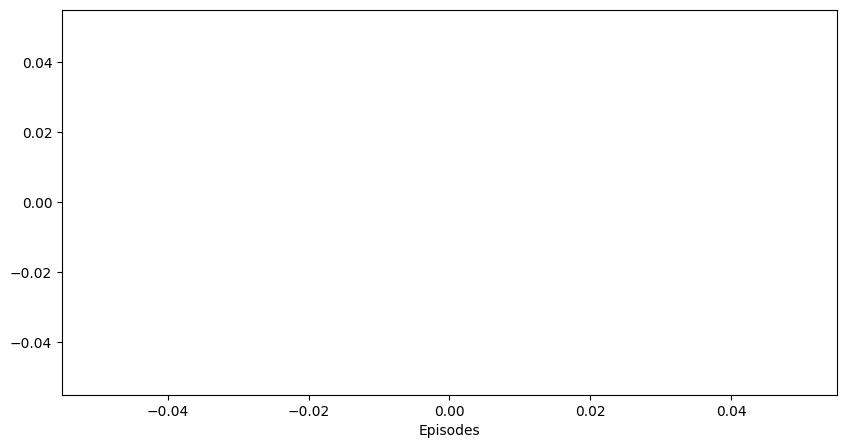

In [5]:
import numpy as np
import gymnasium as gym
from collections import defaultdict
import ale_py
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

scores = []

class QLearningAgent:
    def __init__(self, state_space, action_space, learning_rate=0.1, discount=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.1):
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.discount = discount
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Initialize Q-table as a defaultdict
        self.q_table = defaultdict(lambda: np.zeros(action_space))
    
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_space)  # Exploration
        return np.argmax(self.q_table[state])  # Exploitation
    
    def update_q_table(self, state, action, reward, next_state, done):
        max_future_q = 0 if done else np.max(self.q_table[next_state])
        target = reward + self.discount * max_future_q
        self.q_table[state][action] += self.learning_rate * (target - self.q_table[state][action])
    
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

class PacmanQLearning:
    def __init__(self, env_name='ALE/Pacman-v5', view='human'):
        self.env = gym.make(env_name, frameskip=1, render_mode=view)
        self.env = gym.wrappers.AtariPreprocessing(self.env, frame_skip=4, grayscale_obs=True, screen_size=84)
        self.env.reset()
        
        self.state_space = (84, 84)  # Simplified state representation
        self.action_space = self.env.action_space.n
        
        self.agent = QLearningAgent(self.state_space, self.action_space)
    
    def preprocess_state(self, state):
        return tuple(state.flatten())  # Flatten the state for use as a key in the Q-table
    
    def train(self, episodes=1000, statistics=True, save_path='./'):
        scores = []
        
        for e in tqdm(range(episodes)):
            state, _ = self.env.reset()
            state = self.preprocess_state(state)
            
            done = False
            score = 0
            
            while not done:
                action = self.agent.get_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                
                # Update Q-table
                self.agent.update_q_table(state, action, reward, next_state, done)
                
                state = next_state
                score += reward
            
            # Decay epsilon after each episode
            self.agent.decay_epsilon()
            
            # Logging
            scores.append(score)
            
            if statistics:
                print(f"Episode: {e+1}/{episodes}, Score: {score}, Epsilon: {self.agent.epsilon:.3f}")
        
        # Save Q-table for future use
        np.save(save_path + 'q_table.npy', dict(self.agent.q_table))
        print("Training complete. Q-table saved.")
    
    def play(self, episodes=1):
        for episode in range(episodes):
            state, _ = self.env.reset()
            state = self.preprocess_state(state)
            
            done = False
            score = 0
            
            print(f"Starting Episode {episode + 1}")
            
            while not done:
                self.env.render()  # Render the environment
                action = self.agent.get_action(state)  # Use the agent's policy
                next_state, reward, done, _, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                
                state = next_state
                score += reward
            
            print(f"Episode {episode + 1} ended with score: {score}")
            scores.append(score)
        self.env.close()

# Initialize Pacman Q-learning
pacman = PacmanQLearning()

# Train the agent
pacman.train(episodes=50, statistics=True, save_path='./')

# Plot the scores
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(scores)), scores, color='blue')
plt.xlabel('Episodes')
plt.show()

In [6]:

# Load the Q-table (if saved previously)
try:
    q_table_data = np.load('./q_table.npy', allow_pickle=True).item()
    pacman.agent.q_table.update(q_table_data)
    print("Q-table loaded successfully.")
except FileNotFoundError:
    print("No Q-table found. Starting fresh.")

# # Watch Pac-Man play
# pacman.play(episodes=1)

Q-table loaded successfully.
